In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pickle

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/2', experiment_id='2', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [5]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [6]:
df = pd.read_parquet('/home/ubuntu/data/green_tripdata_2022-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.735793552152567

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


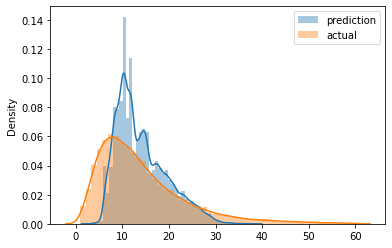

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('/home/ubuntu/data/green_tripdata_2022-01.parquet')
df_val = read_dataframe('/home/ubuntu/data/green_tripdata_2022-02.parquet')

In [11]:
len(df_train), len(df_val)

(59603, 66097)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.928931233573194

In [16]:
with open('/home/ubuntu/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
with mlflow.start_run():
    mlflow.set_tag("developer","shruti")
    mlflow.log_param("train-data-path", "/home/ubuntu/data/green_tripdata_2022-01.parquet")
    mlflow.log_param("val-data-path", "/home/ubuntu/data/green_tripdata_2022-02 .parquet")

    alpha = 0.02
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    mse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("mse",mse)

In [18]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [19]:
train=xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [20]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round = 1000,
            evals = [(valid,"validation")],
            early_stopping_rounds = 50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
    return{'loss':rmse, 'status':STATUS_OK}

In [21]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -2,0),
    'reg_alpha': hp.loguniform('reg_alpha', -5,-1),
    'reg_lambda':hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight':hp.loguniform('min_child_weight', -1, 3),
    'objective':'reg:linear',
    'seed':42,
}

In [22]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=1,
    trials=Trials()
)

[21:46:02] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:9.99774                          
[1]	validation-rmse:7.28486                          
[2]	validation-rmse:6.42528                          
[3]	validation-rmse:6.15662                          
[4]	validation-rmse:6.06002                          
[5]	validation-rmse:6.01723                          
[6]	validation-rmse:5.99384                          
[7]	validation-rmse:5.98452                          
[8]	validation-rmse:5.97349                          
[9]	validation-rmse:5.96838                          
[10]	validation-rmse:5.96538                         
[11]	validation-rmse:5.96191                         
[12]	validation-rmse:5.96025                         
[13]	validation-rmse:5.95674                         
[14]	validation-rmse:5.95079                         
[15]	validation-rmse:5.94836                         
[16]	validation-r

Taking the best parameter fromt he above training to conduct inference

In [23]:
params={
    'learning_rate':0.30496744373957435,
    'max_depth':86,
    'min_child_weight':19.05362965923123,
    'objective':'reg:linear',
    'reg_alpha':0.1387043209444142,
    'reg_lambda':0.26102638998865857,
    'seed':42
}

Autologging without mentioning what to log

In [25]:
mlflow.xgboost.autolog()
#mlflow autolog method works with certain parameters
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round = 10,
    evals = [(valid,"validation")],
    early_stopping_rounds = 50
)

2022/06/26 21:48:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5d4b10f66bd543e4836ce6c5d03dee19', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[21:48:21] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:13.11946
[1]	validation-rmse:10.32095
[2]	validation-rmse:8.58064
[3]	validation-rmse:7.53932
[4]	validation-rmse:6.93805
[5]	validation-rmse:6.59704
[6]	validation-rmse:6.39979
[7]	validation-rmse:6.28321
[8]	validation-rmse:6.21490
[9]	validation-rmse:6.17382


2022/06/26 21:48:25 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2022/06/26 21:48:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."
